In [1]:
from dotenv import load_dotenv

# from langchain_teddynote import logging

load_dotenv()
# logging.langsmith("TeddyNote-Parser")

True

In [2]:
# !pip install -qU langchain-teddynote

## 저장할 State 정의

In [3]:
from typing import TypedDict


# GraphState 상태를 저장하는 용도로 사용합니다.
class GraphState(TypedDict):
    filepath: str  # path
    filetype: str  # pdf
    page_numbers: list[int]  # page numbers
    batch_size: int  # batch size
    split_filepaths: list[str]  # split files
    analyzed_files: list[str]  # analyzed files
    page_elements: dict[int, dict[str, list[dict]]]  # page elements
    page_metadata: dict[int, dict]  # page metadata
    page_summary: dict[int, str]  # page summary
    images: list[str]  # image paths
    image_summary: list[str]  # image summary
    tables: list[str]  # table
    table_summary: dict[int, str]  # table summary
    table_markdown: dict[int, str]  # table markdown
    texts: list[str]  # text
    text_summary: dict[int, str]  # text summary
    table_summary_data_batches: list[dict]  # table summary data batches

## 노드 정의

In [4]:
import os
import graphparser.core as parser_core
import graphparser.layout_utils as layout_utils
import graphparser.pdf as pdf

# import importlib

# importlib.reload(parser_core)
# importlib.reload(layout_utils)
# importlib.reload(pdf)

In [5]:
# 문서 분할
split_pdf_node = pdf.SplitPDFFilesNode(batch_size=10)

# Layout Analyzer
layout_analyze_node = parser_core.LayoutAnalyzerNode(os.environ.get("UPSTAGE_API_KEY"))

# 페이지 요소 추출
page_element_extractor_node = parser_core.ExtractPageElementsNode()

# 이미지 자르기
image_cropper_node = parser_core.ImageCropperNode()

# 테이블 자르기
table_cropper_node = parser_core.TableCropperNode()

# 페이지별 텍스트 추출
extract_page_text = parser_core.ExtractPageTextNode()

# 페이지별 요약
page_summary_node = parser_core.CreatePageSummaryNode(
    api_key=os.environ.get("OPENAI_API_KEY")
)

# 이미지 요약
image_summary_node = parser_core.CreateImageSummaryNode(
    api_key=os.environ.get("OPENAI_API_KEY")
)

# 테이블 요약
table_summary_node = parser_core.CreateTableSummaryNode(
    api_key=os.environ.get("OPENAI_API_KEY")
)

# 테이블 Markdown 추출
table_markdown_extractor = parser_core.TableMarkdownExtractorNode()

## 그래프 정의

In [6]:
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

# LangGraph을 생성
workflow = StateGraph(GraphState)

# 노드들을 정의합니다.
workflow.add_node("split_pdf_node", split_pdf_node())
workflow.add_node("layout_analyzer_node", layout_analyze_node())
workflow.add_node("page_element_extractor_node", page_element_extractor_node())
workflow.add_node("image_cropper_node", image_cropper_node())
workflow.add_node("table_cropper_node", table_cropper_node())
workflow.add_node("extract_page_text_node", extract_page_text())
workflow.add_node("page_summary_node", page_summary_node())
workflow.add_node("image_summary_node", image_summary_node())
workflow.add_node("table_summary_node", table_summary_node())
workflow.add_node("table_markdown_node", table_markdown_extractor())

# 각 노드들을 연결합니다.
workflow.add_edge("split_pdf_node", "layout_analyzer_node")
workflow.add_edge("layout_analyzer_node", "page_element_extractor_node")
workflow.add_edge("page_element_extractor_node", "image_cropper_node")
workflow.add_edge("page_element_extractor_node", "table_cropper_node")
workflow.add_edge("page_element_extractor_node", "extract_page_text_node")
workflow.add_edge("image_cropper_node", "page_summary_node")
workflow.add_edge("table_cropper_node", "page_summary_node")
workflow.add_edge("extract_page_text_node", "page_summary_node")
workflow.add_edge("page_summary_node", "image_summary_node")
workflow.add_edge("page_summary_node", "table_summary_node")
workflow.add_edge("image_summary_node", END)
workflow.add_edge("table_summary_node", "table_markdown_node")
workflow.add_edge("table_markdown_node", END)

workflow.set_entry_point("split_pdf_node")

memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

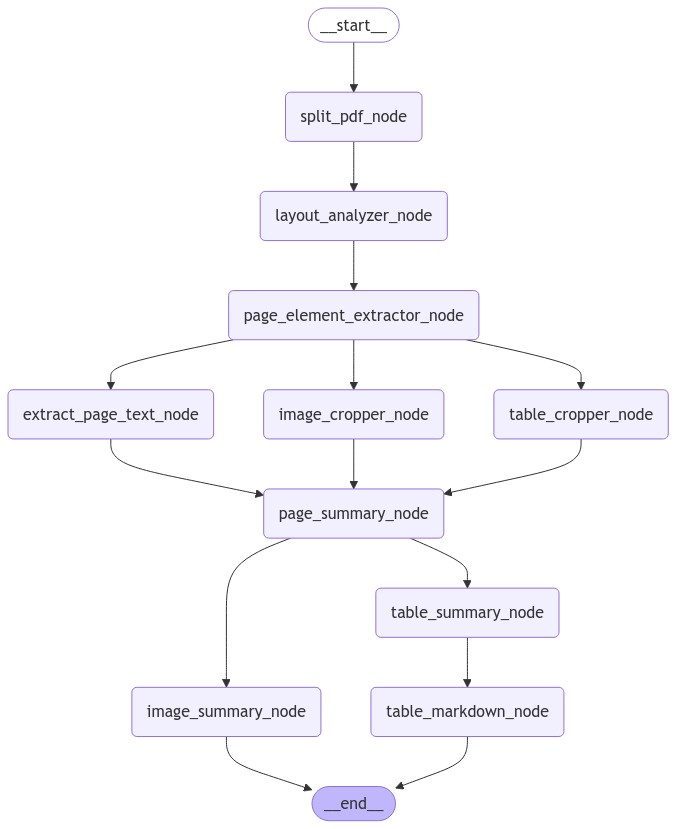

In [7]:
from IPython.display import Image, display

try:
    display(
        Image(app.get_graph(xray=True).draw_mermaid_png())
    )  # 실행 가능한 객체의 그래프를 mermaid 형식의 PNG로 그려서 표시합니다. xray=True는 추가적인 세부 정보를 포함합니다.
except:
    # 이 부분은 추가적인 의존성이 필요하며 선택적으로 실행됩니다.
    pass

In [8]:
import pprint
from langgraph.errors import GraphRecursionError
from langchain_core.runnables import RunnableConfig

config = RunnableConfig(
    recursion_limit=100, configurable={"thread_id": "TeddyNote-Parser"}
)

# AgentState 객체를 활용하여 질문을 입력합니다.
inputs = GraphState(
    filepath="/Users/teddy/Dev/github/teddynote-parser/data/디지털정부혁신추진계획.pdf"
)

# app.stream을 통해 입력된 메시지에 대한 출력을 스트리밍합니다.
try:
    for output in app.stream(inputs, config=config):
        # 출력된 결과에서 키와 값을 순회합니다.
        for key, value in output.items():
            # 노드의 이름과 해당 노드에서 나온 출력을 출력합니다.
            pprint.pprint(f"Output from node '{key}':")
            pprint.pprint("---")
            # 출력 값을 예쁘게 출력합니다.
            # pprint.pprint(value, indent=2, width=80, depth=None)
        # 각 출력 사이에 구분선을 추가합니다.
        pprint.pprint("\n---\n")
except GraphRecursionError as e:
    pprint.pprint(f"Recursion limit reached: {e}")

총 페이지 수: 21
분할 PDF 생성: /Users/teddy/Dev/github/teddynote-parser/data/디지털정부혁신추진계획_0000_0009.pdf
분할 PDF 생성: /Users/teddy/Dev/github/teddynote-parser/data/디지털정부혁신추진계획_0010_0019.pdf
분할 PDF 생성: /Users/teddy/Dev/github/teddynote-parser/data/디지털정부혁신추진계획_0020_0020.pdf
"Output from node 'split_pdf_node':"
'---'
'\n---\n'
"Output from node 'layout_analyzer_node':"
'---'
'\n---\n'
"Output from node 'page_element_extractor_node':"
'---'
'\n---\n'
"Output from node 'extract_page_text_node':"
'---'
'\n---\n'
page:6, id:77, path: /Users/teddy/Dev/github/teddynote-parser/data/디지털정부혁신추진계획/77.png
page:7, id:87, path: /Users/teddy/Dev/github/teddynote-parser/data/디지털정부혁신추진계획/87.png
page:10, id:120, path: /Users/teddy/Dev/github/teddynote-parser/data/디지털정부혁신추진계획/120.png
page:10, id:125, path: /Users/teddy/Dev/github/teddynote-parser/data/디지털정부혁신추진계획/125.png
page:12, id:147, path: /Users/teddy/Dev/github/teddynote-parser/data/디지털정부혁신추진계획/147.png
page:12, id:150, path: /Users/teddy/Dev/github/teddynote-pars

In [9]:
state = app.get_state(config).values

In [10]:
from langchain_core.documents import Document

markdowns = []
docs = []

for page_number in state["page_elements"].keys():
    page = state["page_elements"][page_number]

    for element in page["elements"]:
        if element["category"] == "figure":
            image_summary = state["image_summary"][str(element["id"])]
            markdowns.append(image_summary)

            image_path = state["images"][str(element["id"])]
            markdowns.append(f"![{image_path}]({image_path})")
            doc = Document(
                page_content=image_summary,
                metadata={
                    "image": image_path,
                    "page": page_number,
                    "source": state["filepath"],
                },
            )
            docs.append(doc)

        elif element["category"] == "table":
            table_summary = state["table_summary"][str(element["id"])]
            table_markdown = state["table_markdown"][str(element["id"])]

            table_path = state["tables"][str(element["id"])]
            markdowns.append(f"![{table_path}]({table_path})")
            markdowns.append(table_summary)
            markdowns.append(table_markdown)

            doc = Document(
                page_content=f"{table_summary}\n<table_content>{table_markdown}</table_content>",
                metadata={
                    "table": table_path,
                    "page": page_number,
                    "source": state["filepath"],
                },
            )
            docs.append(doc)
        else:
            text = element["text"]
            markdowns.append(text)
            doc = Document(
                page_content=text,
                metadata={
                    "page": page_number,
                    "source": state["filepath"],
                },
            )
            docs.append(doc)

In [11]:
# Markdown 파일로 텍스트 저장
with open("output.md", "w", encoding="utf-8") as f:
    f.write("\n\n".join(markdowns))

print("텍스트가 'output.md' 파일로 저장되었습니다.")

텍스트가 'output.md' 파일로 저장되었습니다.


In [ ]:
len(docs)